In [786]:
# Load packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
from math import sqrt

In [1179]:
# Functions and parameters

# Date parser
dateparse = lambda dates: [pd.datetime.strptime(d, '%d/%m/%Y') for d in dates]

# Plot size
_figsize = (20,5)

_days_per_year = 365.0
_initial_cap = 100.0

def scale(data):
    return (data - data.min()) * 1.0 / (data.max() - data.min())

def load_funds(filename):
    fund_names = pd.read_csv(filename, skiprows=3, nrows=1, usecols=[1,3]).columns
    col_names = ['Total Return', 'Last Price']

    raw_data = pd.read_csv(filename, skiprows=5, parse_dates=True, date_parser=dateparse, index_col='Dates')
    funds={}
    for i in range(0, len(raw_data.columns)/2):
        funds[i] = raw_data.iloc[:,i*2:i*2+2].dropna()
        funds[i].columns = col_names
        
    return funds, fund_names

def load_signals(filename):
    sheet_name = 'StrategyDetails'
    index_col = 'Date'
    usecols = [0, 3]
    return pd.read_excel(open(filename, 'rb'), sheet_name=sheet_name, parse_dates=True, 
                         index_col=index_col, usecols=usecols)

def process_fund(signal, funds):
    
    for fidx in funds:
    
        funds[fidx] = get_pct_change(funds[fidx])
        funds[fidx] = pd.concat([signal, funds[fidx]],axis=1).dropna()
    
        for idx in funds[fidx].index:
            if idx == funds[fidx].index[0]:
                funds[fidx].loc[idx,'Strategy on Total Return'] = _initial_cap 
                funds[fidx].loc[idx,'Strategy on Total Return %'] = 0.0
                funds[fidx].loc[idx,'Drawdown of Strategy on Total Return'] = 0.0
                
                funds[fidx].loc[idx,'Strategy on Last Price'] = _initial_cap 
                funds[fidx].loc[idx,'Strategy on Last Price %'] = 0.0
                funds[fidx].loc[idx,'Drawdown of Strategy on Last Price'] = 0.0
                
                funds[fidx].loc[idx,'No Strategy on Total Return'] = _initial_cap 
                funds[fidx].loc[idx,'No Strategy on Total Return %'] = 0.0
                funds[fidx].loc[idx,'Drawdown of No Strategy on Total Return'] = 0.0
                
                funds[fidx].loc[idx,'No Strategy on Last Price'] = _initial_cap 
                funds[fidx].loc[idx,'No Strategy on Last Price %'] = 0.0
                funds[fidx].loc[idx,'Drawdown of No Strategy on Last Price'] = 0.0
            else: 
                prev_idx = get_prev_idx(funds[fidx], idx)
                funds[fidx].loc[idx,'Strategy on Total Return'] = get_cummulative_return(funds[fidx].loc[idx,'Exposure'], funds[fidx].loc[prev_idx,'Strategy on Total Return'], funds[fidx].loc[idx,'Total Return % Change'])
                funds[fidx].loc[idx,'Strategy on Total Return %'] = round((funds[fidx].loc[idx,'Strategy on Total Return'] / _initial_cap - 1) *100,2)
                funds[fidx].loc[idx,'Drawdown of Strategy on Total Return'] = get_drawdown(funds[fidx]['Strategy on Total Return'].dropna())
                
                funds[fidx].loc[idx,'Strategy on Last Price'] = get_cummulative_return(funds[fidx].loc[idx,'Exposure'], funds[fidx].loc[prev_idx,'Strategy on Last Price'], funds[fidx].loc[idx,'Last Price % Change'])
                funds[fidx].loc[idx,'Strategy on Last Price %'] = round((funds[fidx].loc[idx,'Strategy on Last Price'] / _initial_cap - 1) *100,2)
                funds[fidx].loc[idx,'Drawdown of Strategy on Last Price'] = get_drawdown(funds[fidx]['Strategy on Last Price'].dropna())
                
                funds[fidx].loc[idx,'No Strategy on Total Return'] = get_cummulative_return(1, funds[fidx].loc[prev_idx,'No Strategy on Total Return'], funds[fidx].loc[idx,'Total Return % Change'])
                funds[fidx].loc[idx,'No Strategy on Total Return %'] = round((funds[fidx].loc[idx,'No Strategy on Total Return'] / _initial_cap - 1) *100,2)
                funds[fidx].loc[idx,'Drawdown of No Strategy on Total Return'] = get_drawdown(funds[fidx]['No Strategy on Total Return'].dropna())
                
                funds[fidx].loc[idx,'No Strategy on Last Price'] = get_cummulative_return(1, funds[fidx].loc[prev_idx,'No Strategy on Last Price'], funds[fidx].loc[idx,'Last Price % Change'])
                funds[fidx].loc[idx,'No Strategy on Last Price %'] = round((funds[fidx].loc[idx,'No Strategy on Last Price'] / _initial_cap - 1) *100,2)
                funds[fidx].loc[idx,'Drawdown of No Strategy on Last Price'] = get_drawdown(funds[fidx]['No Strategy on Last Price'].dropna())
                    
    return funds
    
def get_pct_change(df):
    for col_name in df.columns:
            df[col_name+' % Change'] = df[col_name].pct_change().fillna(0)
    return df

def get_next_idx(df, idx):
    return df.index[df.index.get_loc(idx) + 1]

def get_prev_idx(df, idx):
    return df.index[df.index.get_loc(idx) - 1]

# Days Held = Final (Current) Date - Date of Inception
def get_days_held(df):
    return abs((df.last_valid_index() - df.first_valid_index()).days)

# Cumulative Return = Previous Total Return * (Signal * % Change of Price + 1)                    
def get_cummulative_return(signal, prev_return, pct_change):                    
    return prev_return * (signal * pct_change + 1)

# Drawdown = Current Value / Max(All Previous Values) - 1
def get_drawdown(df):
    return df.iloc[-1] / df.max() - 1.0

def get_max_drawdown(drawdowns):
    return drawdowns.min().tolist()

# Annualized Return = (1 + Cumulative Return % ) ^ (365 / Days Held) - 1
def get_annualized_return(cum_returns, days_held):
    annualized_returns = []
    for cum_return in cum_returns.tolist():
        annualized_returns.append(((1 + cum_return / 100.0)**(_days_per_year / days_held) - 1) *100.0)
    return annualized_returns

# Volatility = std(Total Return time series)
def get_volatility(tot_returns):
    return tot_returns.std().tolist()
    
# Annualized Volatility = Volatility * sqrt(Days per Year / Days Held)    
def get_annualized_volatility(vols, days_held):
    annualized_vols=[]
    for vol in vols:
        annualized_vols.append(vol * sqrt(_days_per_year/days_held))
    return annualized_vols

# Sharp Ratio = Cumulative Return / Volatility
def get_sharp_ratio(cum_return, volatility):
    return cum_return/volatility


In [1188]:
# Input files
funds_file = './funds.csv'
signals_file = 'N:\Portfolio Management\Model_engine\ostricamomentum\Used backtests\DM\\20181011130203-production-dm-strategy-details.xlsx'

# Load data
funds, fund_names = load_funds(funds_file)
exposure_signal = load_signals(signals_file)

funds = process_fund(exposure_signal, funds)


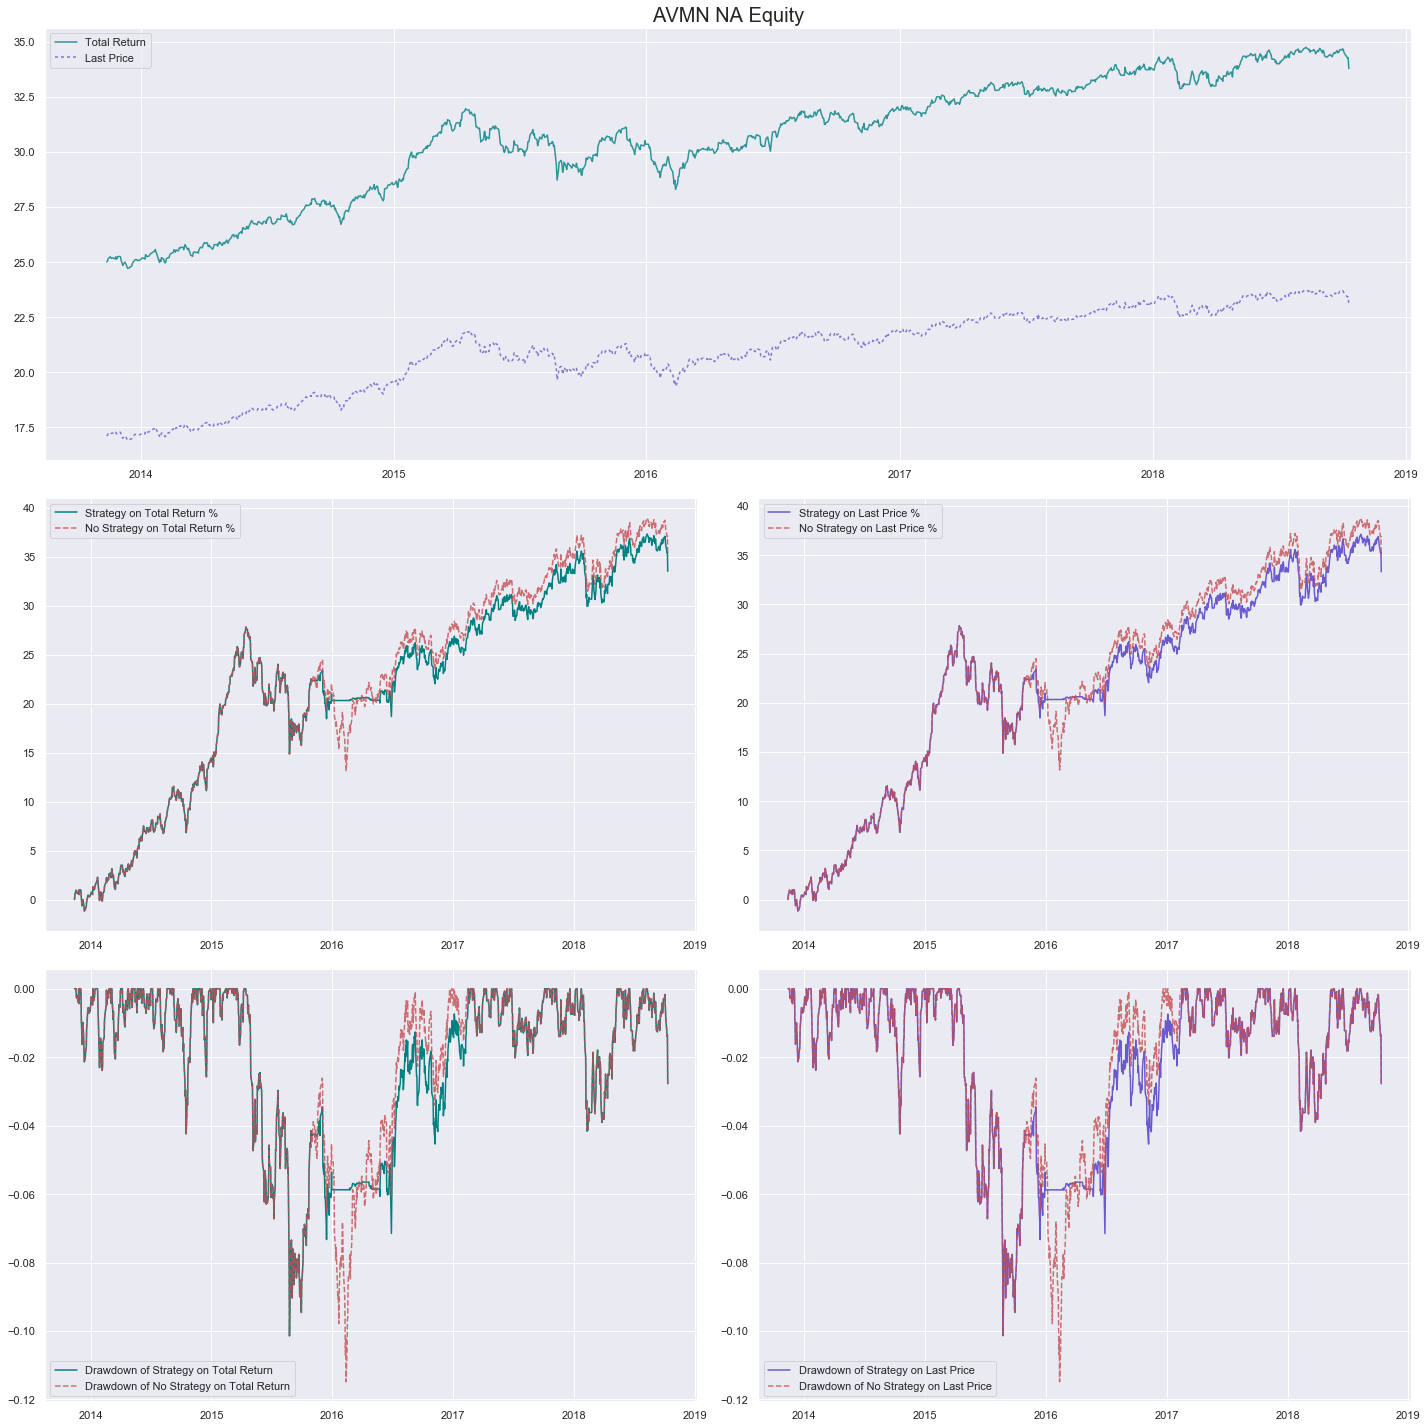

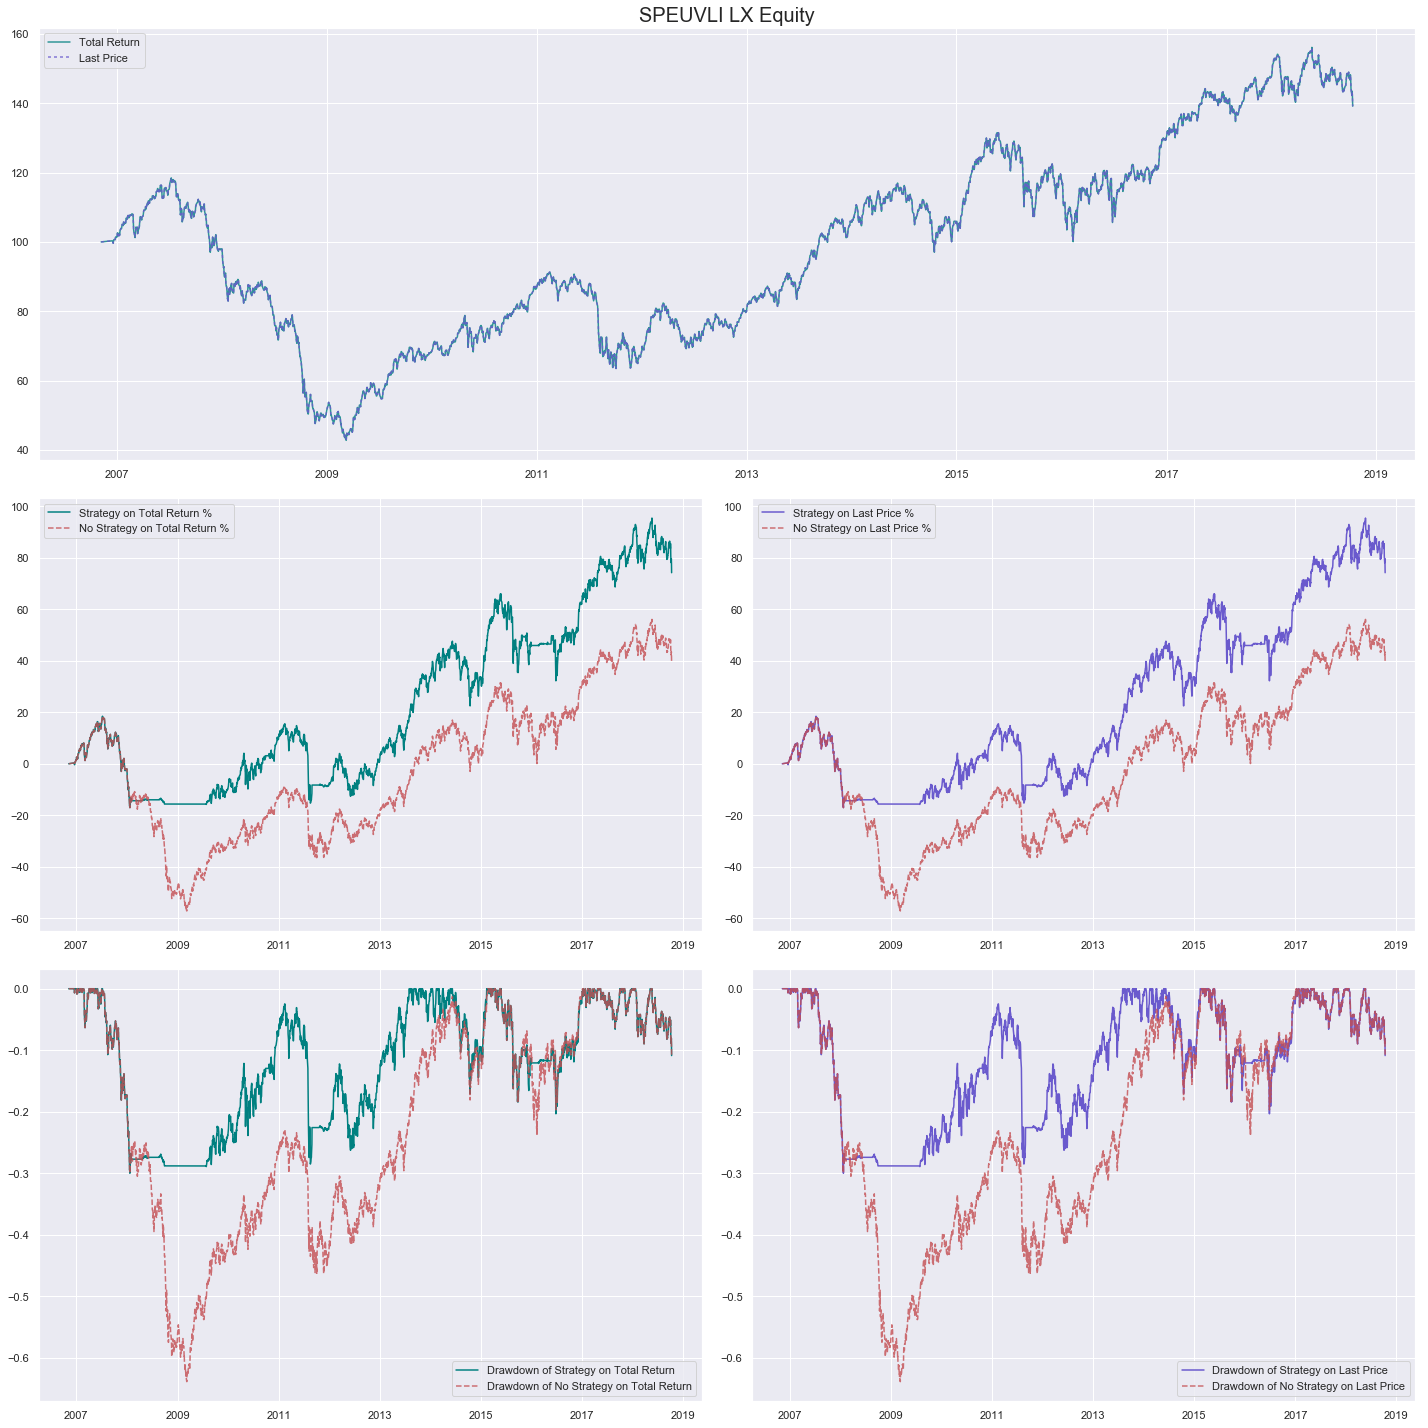

In [1252]:
# Plot results

for fidx in range(0,len(funds)):
    
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(3, 2)
    
    ax0 = plt.subplot(gs[0:1,:])
    line, = ax0.plot(funds[fidx]['Total Return'], 'teal', alpha=0.8)
    line2, = ax0.plot(funds[fidx]['Last Price'], 'slateblue', alpha=0.8)
    line2.set_dashes([2, 2])
    ax0.legend(['Total Return', 'Last Price'])
    ax0.set_title(fund_names[fidx], fontsize=20)
    
    ax1 = plt.subplot(gs[1:2,0])
    ax1.plot(funds[fidx]['Strategy on Total Return %'], 'teal', linewidth=1.5, alpha=1)
    ax1.plot(funds[fidx]['No Strategy on Total Return %'], 'r--', linewidth=1.5, alpha=0.8)
    ax1.legend(['Strategy on Total Return %', 'No Strategy on Total Return %'])
    
    ax2 = plt.subplot(gs[1:2,1])
    ax2.plot(funds[fidx]['Strategy on Last Price %'], 'slateblue', linewidth=1.5, alpha=1)
    ax2.plot(funds[fidx]['No Strategy on Last Price %'], 'r--', linewidth=1.5, alpha=0.8)
    ax2.legend(['Strategy on Last Price %', 'No Strategy on Last Price %'])
    
    ax3 = plt.subplot(gs[2:3,0])
    ax3.plot(funds[fidx]['Drawdown of Strategy on Total Return'], 'teal', linewidth=1.5, alpha=1)
    ax3.plot(funds[fidx]['Drawdown of No Strategy on Total Return'], 'r--', linewidth=1.5, alpha=0.8)
    ax3.legend(['Drawdown of Strategy on Total Return', 'Drawdown of No Strategy on Total Return'])
    
    ax4 = plt.subplot(gs[2:3,1])
    ax4.plot(funds[fidx]['Drawdown of Strategy on Last Price'], 'slateblue', linewidth=1.5, alpha=1)
    ax4.plot(funds[fidx]['Drawdown of No Strategy on Last Price'], 'r--', linewidth=1.5, alpha=0.8)
    ax4.legend(['Drawdown of Strategy on Last Price', 'Drawdown of No Strategy on Last Price'])
    
    plt.tight_layout()
    plt.savefig(fund_names[fidx]+'.png')
    plt.show()


In [1184]:


days_held = get_days_held(funds[0])

stats_tot_return = pd.DataFrame(index=['Strategy', 'No Strategy'])
stats_last_price = pd.DataFrame(index=['Strategy', 'No Strategy'])

stats_tot_return['Cumulative Return'] = [funds[0]['Strategy on Total Return %'].iat[-1], funds[0]['No Strategy on Total Return %'].iat[-1]]
stats_tot_return['Annualized Cumulative Return'] = get_annualized(stats_tot_return['Cumulative Return'], days_held)
stats_tot_return['Volatility'] = get_volatility(funds[0][['Strategy on Total Return %', 'No Strategy on Total Return %']])
stats_tot_return['Annualized Volatility'] = get_annualized_volatility(stats_tot_return['Volatility'], days_held)
stats_tot_return['Sharp Ratio'] = get_sharp_ratio(stats_tot_return['Cumulative Return'], stats_tot_return['Volatility'])
stats_tot_return['Max Drawdown'] = get_max_drawdown(funds[0][['Drawdown of Strategy on Total Return', 'Drawdown of No Strategy on Total Return']])

stats_tot_return.transpose()


,Strategy,No Strategy
Cumulative Return,33.520000,35.100000
Annualized Cumulative Return,6.061410,6.315708
Volatility,10.269158,10.912819
Annualized Volatility,4.633307,4.923719
Sharp Ratio,3.264143,3.216401
Max Drawdown,-0.101439,-0.114800


In [1254]:
usecols1 = ['Exposure', 
           'Total Return',
           'Total Return % Change', 
           'Strategy on Total Return %', 
           'No Strategy on Total Return %', 
           'Drawdown of Strategy on Total Return', 'Drawdown of No Strategy on Total Return']

usecols2 = ['Exposure', 
           'Last Price',
           'Last Price % Change', 
           'Strategy on Last Price %', 
           'No Strategy on Last Price %', 
           'Drawdown of Strategy on Last Price', 'Drawdown of No Strategy on Last Price']

# Output results
with pd.ExcelWriter('output.xlsx') as writer:
    for fidx in range(0, len(funds)):
        worksheet = writer.add_worksheet()
        funds[fidx][usecols1].to_excel(writer, sheet_name=(fund_names[fidx]+'-Total Return'))
        funds[fidx][usecols2].to_excel(writer, sheet_name=(fund_names[fidx]+'-Last Price'))

AttributeError: '_XlsxWriter' object has no attribute 'add_worksheet'

In [1263]:
# Load packages
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate a histogram of normal distributed samples
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 1000)

img_file = 'SPEUVLI LX Equity.png'

# Create excel file.
file_name = 'example.xlsx'
workbook = xlsxwriter.Workbook(file_name)
worksheet = workbook.add_worksheet()

# Widen the first column to make the text clearer.
worksheet.set_column('A:A', 30)

# Insert an image.
worksheet.write('A2', 'Insert an image in a cell:')
worksheet.insert_image('B2', img_file)

# Insert an image offset in the cell.
worksheet.write('A12', 'Insert an image with an offset:')
worksheet.insert_image('B12', img_file, {'x_offset': 15, 'y_offset': 10})

# Insert an image with scaling.
worksheet.write(stats_tot_return)
worksheet.insert_image('B23', img_file, {'x_scale': 0.5, 'y_scale': 0.5})

workbook.close()

TypeError: int() argument must be a string or a number, not 'DataFrame'